In [37]:
cd

/Users/keithwalcott


In [38]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm
from itertools import combinations
import plotly.graph_objs as go
import plotly.express as px
from ipywidgets import widgets

In [40]:
# Replace with the path to your folder containing functional score CSV files
folder_path = '/Users/keithwalcott/kw_dms/BD_results/func_scores'

# Initialize an empty dictionary
func_scores_dict = {}

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Create the key for the dictionary (filename without '.csv')
        dict_key = filename[:-4]

        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(folder_path, filename))

        # Add the DataFrame to the dictionary
        func_scores_dict[dict_key] = df

# # Print dictionary keys
# print("Dictionary keys:")
# for key in func_scores_dict.keys():
#     print(key)

# # Print the first few rows of each DataFrame
# for name, df in func_scores_dict.items():
#     print(f"\nFirst few rows of DataFrame '{name}':")
#     print(df.head())

In [41]:
# Replace with the path to your folder containing barcode count CSV files
folder_path = '/Users/keithwalcott/kw_dms/BD_results/barcode_counts'

# Initialize an empty dictionary
barcode_counts_dict = {}

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Create the key for the dictionary (filename without '.csv')
        dict_key = filename[:-4]

        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(folder_path, filename))

        # Add the DataFrame to the dictionary
        barcode_counts_dict[dict_key] = df

for key, df in barcode_counts_dict.items():
    # Check if 'count' column exists in the DataFrame
    if 'count' in df.columns:
        # Rename the 'count' column to include the key as a prefix
        df = df.rename(columns={'count': f'{key}_count'})
        barcode_counts_dict[key] = df
        
# # Print dictionary keys
# print("Dictionary keys:")
# for key in barcode_counts_dict.keys():
#     print(key)

# # Print the first few rows of each DataFrame
# for name, df in barcode_counts_dict.items():
#     print(f"\nFirst few rows of DataFrame '{name}':")
#     print(df.head())

Merge barcode counts with the functional effect dataframes

In [42]:
merged_dict = {}

for func_key in func_scores_dict.keys():
    # Split the key into two parts
    parts = func_key.split('-vs-')
    if len(parts) == 2:
        # Merge the first part
        if parts[0] in barcode_counts_dict:
            merged_df = pd.merge(func_scores_dict[func_key], barcode_counts_dict[parts[0]], on='barcode', how='inner')
        else:
            continue  # Skip if no matching key is found

        # Merge the second part
        if parts[1] in barcode_counts_dict:
            merged_df = pd.merge(merged_df, barcode_counts_dict[parts[1]], on='barcode', how='inner')
        
        # Store the merged DataFrame in the new dictionary
        merged_dict[func_key] = merged_df

# Print dictionary keys
print("Dictionary keys:")
for key in merged_dict.keys():
    print(key)

# Print the first few rows of each DataFrame
for name, df in merged_dict.items():
    print(f"\nFirst few rows of DataFrame '{name}':")
    print(df.head())

Dictionary keys:
Lib2_B1T1-vs-high_B2T1
Lib2_B1T1-vs-medium_B2T1
Lib1_B1T1-vs-medium_B1T1
Lib3_B2T1-vs-BA1_B2T1
Lib3_B1T1-vs-BA1_B1T1
Lib1_B1T1-vs-high_B1T1

First few rows of DataFrame 'Lib2_B1T1-vs-high_B2T1':
   func_score  func_score_var           barcode aa_substitutions  \
0       4.183         0.03916  CAATACTGATATTGTC              NaN   
1       3.419         0.04033  CGACTATAATTTGATA      D80G K1205R   
2       3.207         0.01170  GGACAGATATCCACAT           K1157E   
3       3.140         0.01332  TTTATGGACCACAGAA              NaN   
4       3.081         0.02140  AATCTCGAGTTAGAGG              NaN   

   n_aa_substitutions  n_codon_substitutions  Lib2_B1T1_count  high_B2T1_count  
0                   0                      0               55             1252  
1                   2                      2               55              737  
2                   1                      1              193             2219  
3                   0                      0           

In [43]:
# specific_key = '4u8c_B2T1-vs-DMSO_B1T2'  # Replace 'your_key' with the actual key you want to use

# # Access the DataFrame using the key
# specific_df = merged_dict[key]

# # Display the column names
# print(df.columns)

In [44]:
grouped_dataframes = {'Lib1': [], 'Lib2': [], 'Lib3': []}

for df_name, df in merged_dict.items():
    if df_name.startswith('Lib1'):
        grouped_dataframes['Lib1'].append((df_name, df))
    elif df_name.startswith('Lib2'):
        grouped_dataframes['Lib2'].append((df_name, df))
    elif df_name.startswith('Lib3'):
        grouped_dataframes['Lib3'].append((df_name, df))

In [45]:
from itertools import combinations

merged_group_dict = {}

for group, df_tuples in grouped_dataframes.items():
    for (key1, df1), (key2, df2) in combinations(df_tuples, 2):
        # Rename 'func_score' and 'func_score_var' columns
        df1 = df1.rename(columns={
            'func_score': f'{key1}_func_score',
            'func_score_var': f'{key1}_func_score_var'
        })
        df2 = df2.rename(columns={
            'func_score': f'{key2}_func_score',
            'func_score_var': f'{key2}_func_score_var'
        })

        # Merge DataFrames pairwise
        merged_df = pd.merge(df1, df2, on=['barcode', 'n_aa_substitutions', 'n_codon_substitutions'], how='outer')

        # Immediately drop rows with NaNs in either of the func_score columns
        func_score_cols = [col for col in merged_df.columns if '_func_score' in col]
        merged_df.dropna(subset=func_score_cols, inplace=True)

        # Process duplicate '_count' columns
        count_columns_x = [col for col in merged_df.columns if col.endswith('_x') and '_count' in col]
        count_columns_y = [col for col in merged_df.columns if col.endswith('_y') and '_count' in col]

        for col_x, col_y in zip(count_columns_x, count_columns_y):
            base_col = col_x.replace('_x', '')
            merged_df[base_col] = merged_df[col_x].fillna(merged_df[col_y])
            merged_df.drop(columns=[col_x, col_y], inplace=True)

        # Store the merged DataFrame
        merged_group_dict[f'{key1}-and-{key2}'] = merged_df


In [ ]:
specific_key = '4u8c_B2T1-vs-DMSO_B1T2-and-4u8c_B2T2-vs-DMSO_B1T1'  # Replace this with the actual key you want to use

# Access the DataFrame using the key
specific_df = merged_group_dict[specific_key]

# Display the column names
print(specific_df.columns)


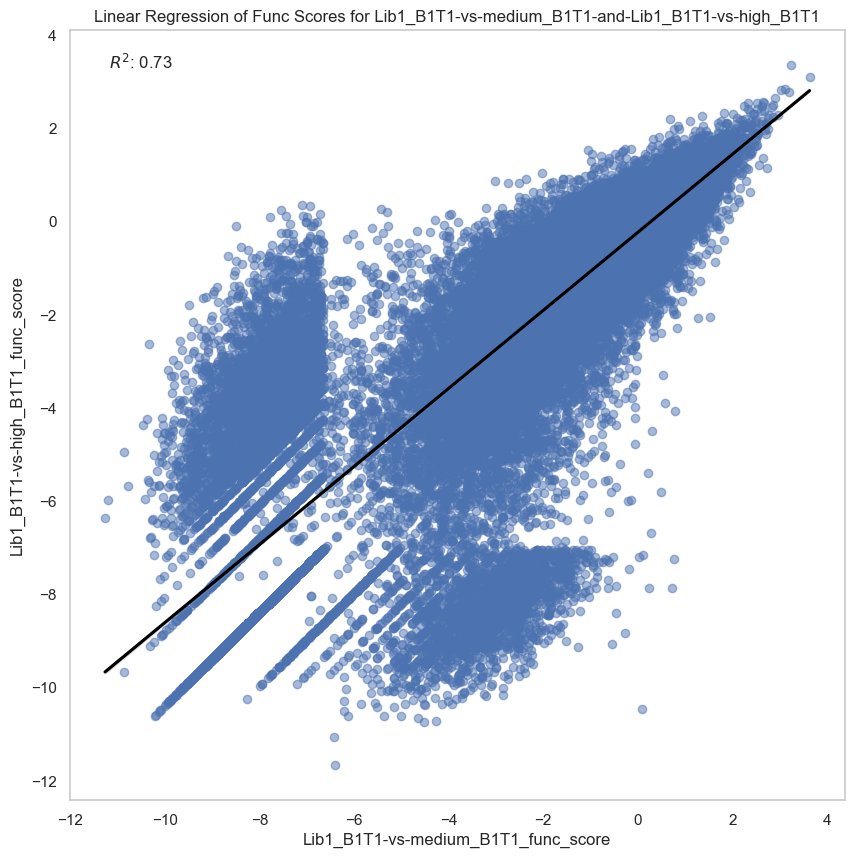

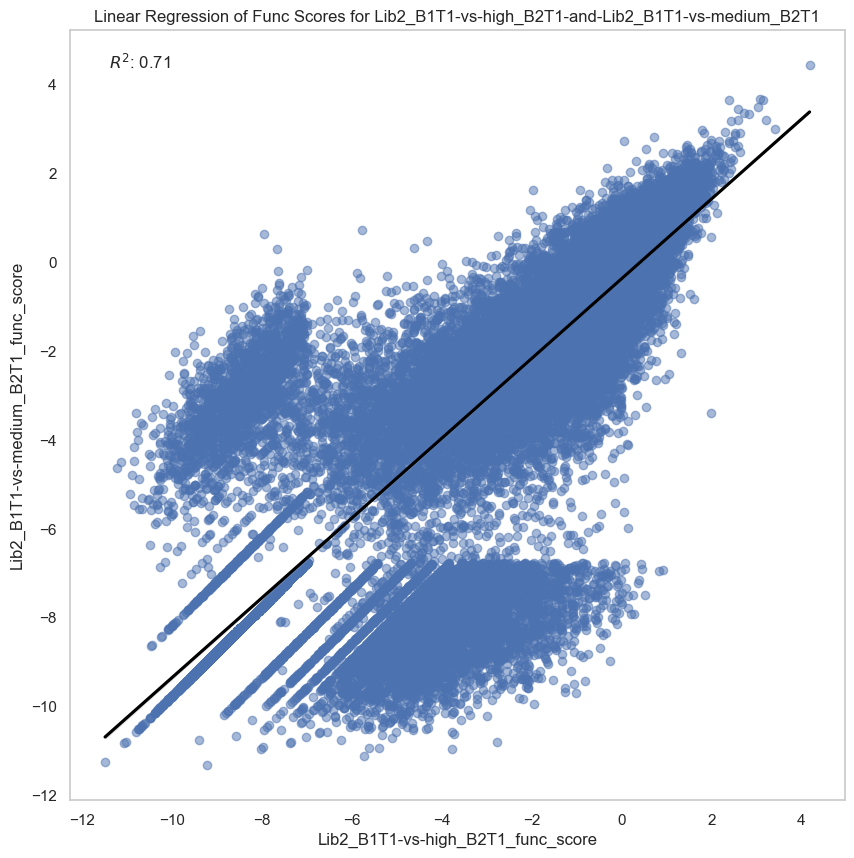

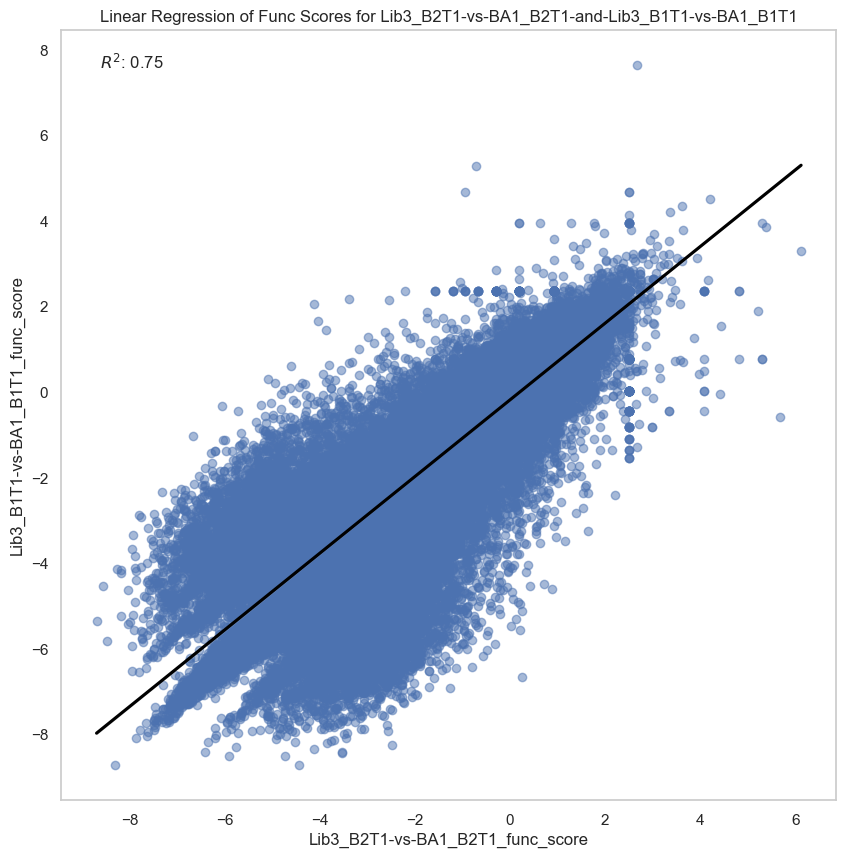

In [46]:
# Set plot style
sns.set(style='whitegrid')

for key, df in merged_group_dict.items():
    # Filter out '_func_score_var' columns and select only '_func_score' columns
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]
    
    # Increase plot size
    plt.figure(figsize=(10, 10))

    # Create the scatter plot with a linear regression line
    sns.regplot(x=func_score_columns[0], y=func_score_columns[1], data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})

    # Calculate and annotate the R^2 value
    slope, intercept, r_value, p_value, std_err = linregress(df[func_score_columns[0]], df[func_score_columns[1]])
    plt.annotate(f'$R^2$: {r_value**2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

    # Customize the plot
    plt.xlabel(func_score_columns[0])
    plt.ylabel(func_score_columns[1])
    plt.title(f'Linear Regression of Func Scores for {key}')

    # Remove grid lines
    plt.grid(False)

    # Show or save the plot
    plt.show()
    # Uncomment to save the plot instead of showing it
    # plt.savefig(f'{key}_scatter_plot.png')

    # Close the plot to avoid overlapping plots in the next iteration
    plt.close()


In [47]:
def calculate_n_selections_optimized(df, threshold):
    # Filter for non-DMSO count columns
    non_dmso_count_cols = [col for col in df.columns if '_count' in col and 'Lib' not in col]

    # Use vectorized comparison and sum across rows
    df['n_selections'] = (df[non_dmso_count_cols] >= threshold).sum(axis=1)

    return df

threshold = 3
for key in merged_group_dict:
    merged_group_dict[key] = calculate_n_selections_optimized(merged_group_dict[key], threshold)


/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

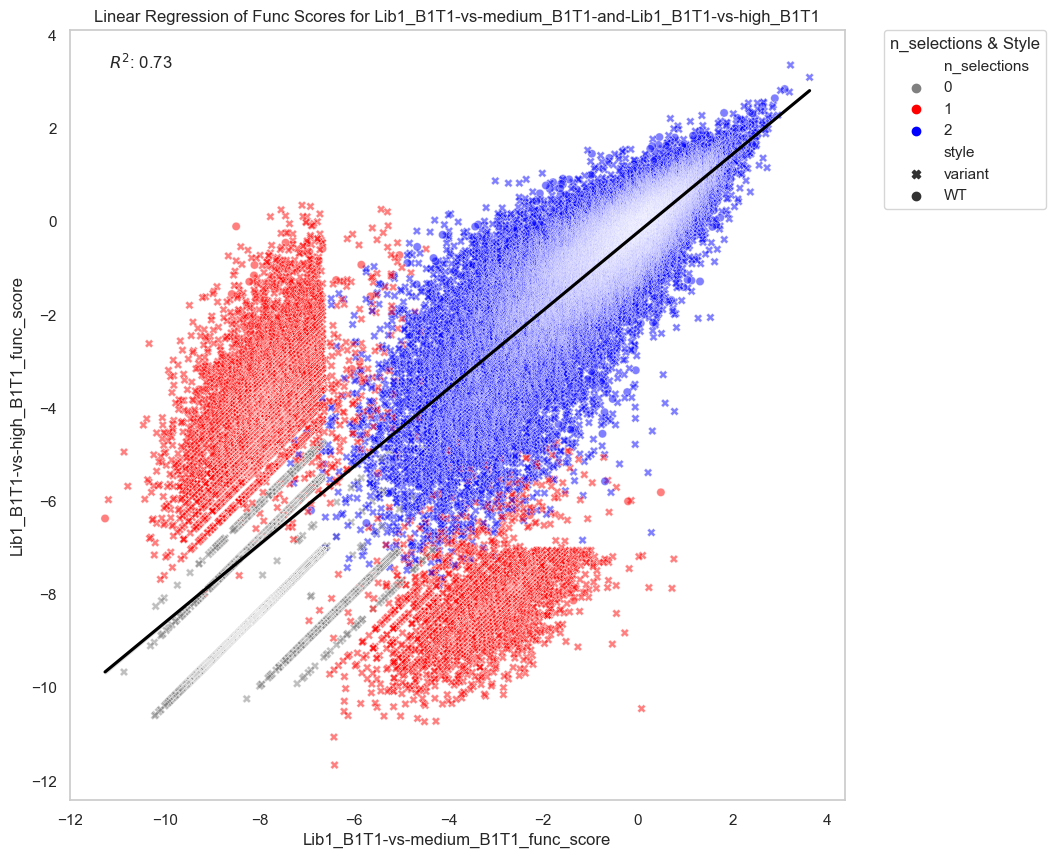

/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

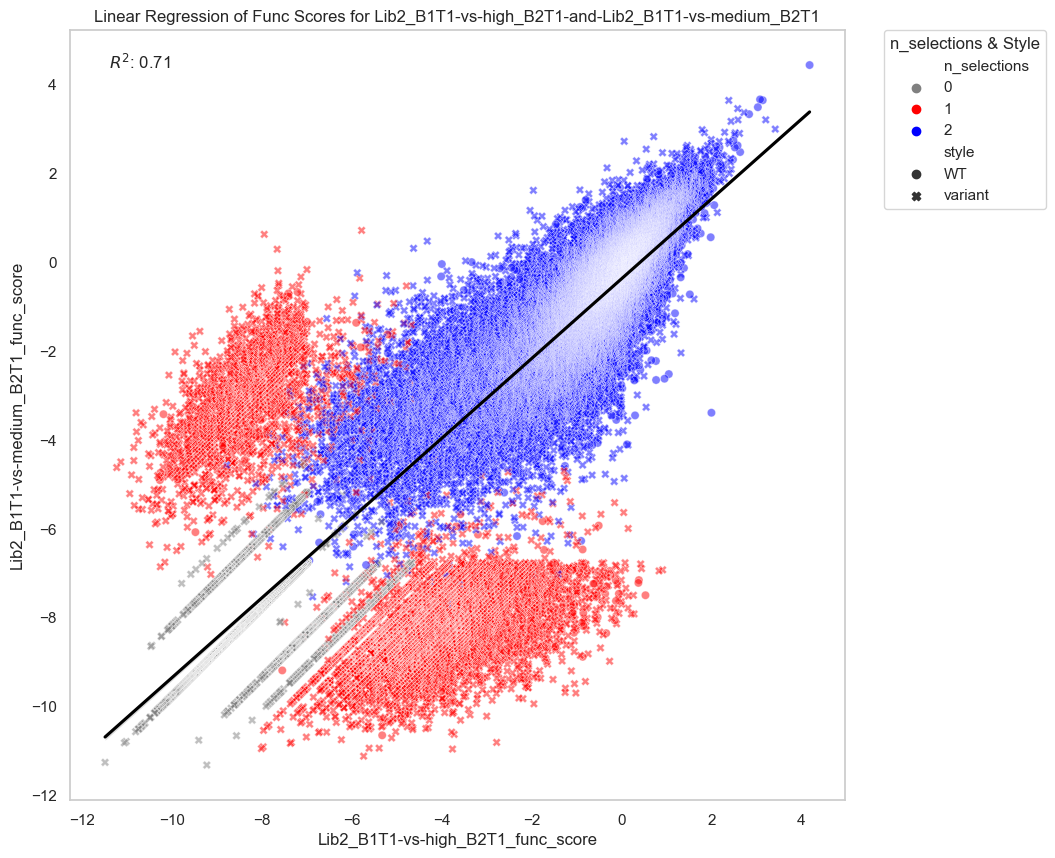

/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

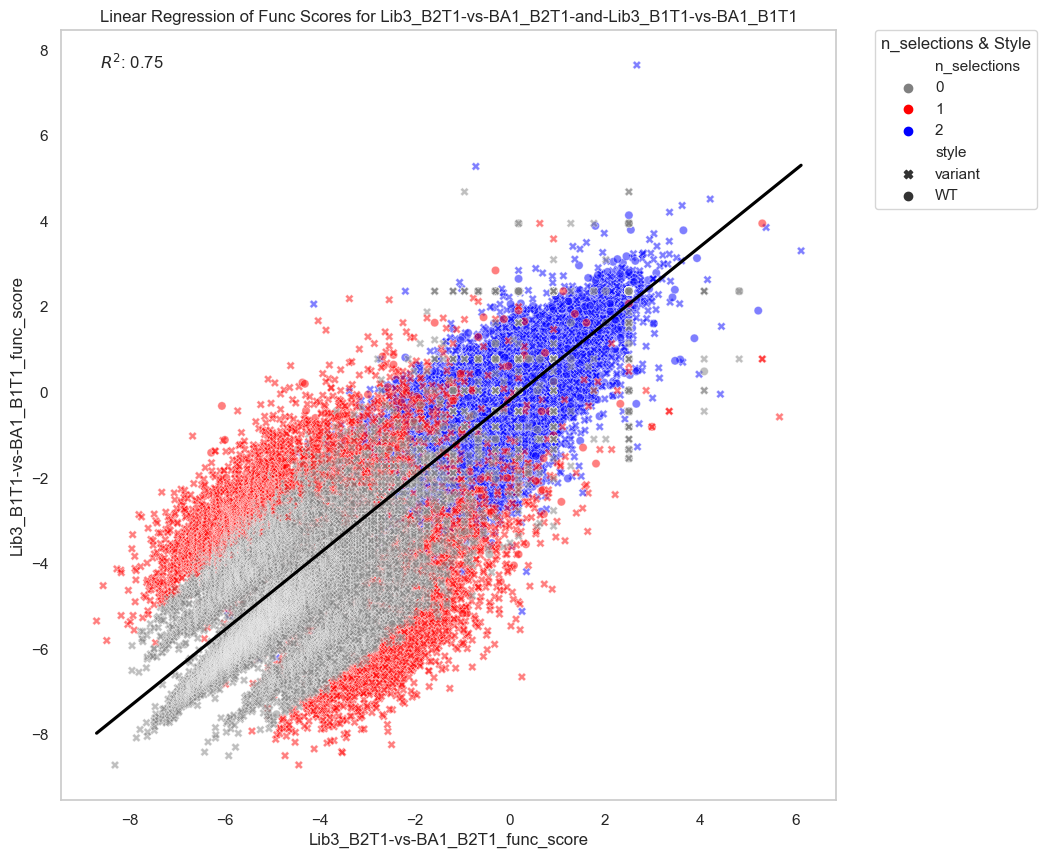

In [48]:
# Set plot style
sns.set(style='whitegrid')

# Define colors for n_selections
palette = {0: 'grey', 1: 'red', 2: 'blue'}

for key, df in merged_group_dict.items():
    # Filter out '_func_score_var' columns and select only '_func_score' columns
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]
    
    # Drop rows with NaN values
    df_clean = df.dropna(subset=func_score_columns)

    # Define a new column for point style based on n_aa_substitutions
    df_clean['style'] = df_clean['n_aa_substitutions'].apply(lambda x: 'variant' if x > 0 else 'WT')

    # Increase plot size
    plt.figure(figsize=(10, 10))

    # Create the scatter plot with a linear regression line in black
    sns.regplot(x=func_score_columns[0], y=func_score_columns[1], data=df_clean, line_kws={'color': 'black'}, scatter=False)

    # Create the scatter plot with color by n_selections and style by n_aa_substitutions
    sns.scatterplot(x=func_score_columns[0], y=func_score_columns[1], data=df_clean, hue='n_selections', style='style', palette=palette, markers={'variant': 'X', 'WT': 'o'}, alpha=0.5)

    # Calculate and annotate the R^2 value
    slope, intercept, r_value, p_value, std_err = linregress(df_clean[func_score_columns[0]], df_clean[func_score_columns[1]])
    plt.annotate(f'$R^2$: {r_value**2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

    # Customize the plot
    plt.xlabel(func_score_columns[0])
    plt.ylabel(func_score_columns[1])
    plt.title(f'Linear Regression of Func Scores for {key}')

    # Remove grid lines
    plt.grid(False)

    # Adjust legend position and combine legends for hue and style
    handles, labels = plt.gca().get_legend_handles_labels()
    n_selection_handles = handles[:len(palette)]
    n_selection_labels = labels[:len(palette)]
    style_handles = handles[len(palette):]
    style_labels = labels[len(palette):]
    plt.legend(n_selection_handles + style_handles, n_selection_labels + style_labels, title='n_selections & Style', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Show or save the plot
    plt.show()

    # Close the plot to avoid overlapping plots in the next iteration
    plt.close()

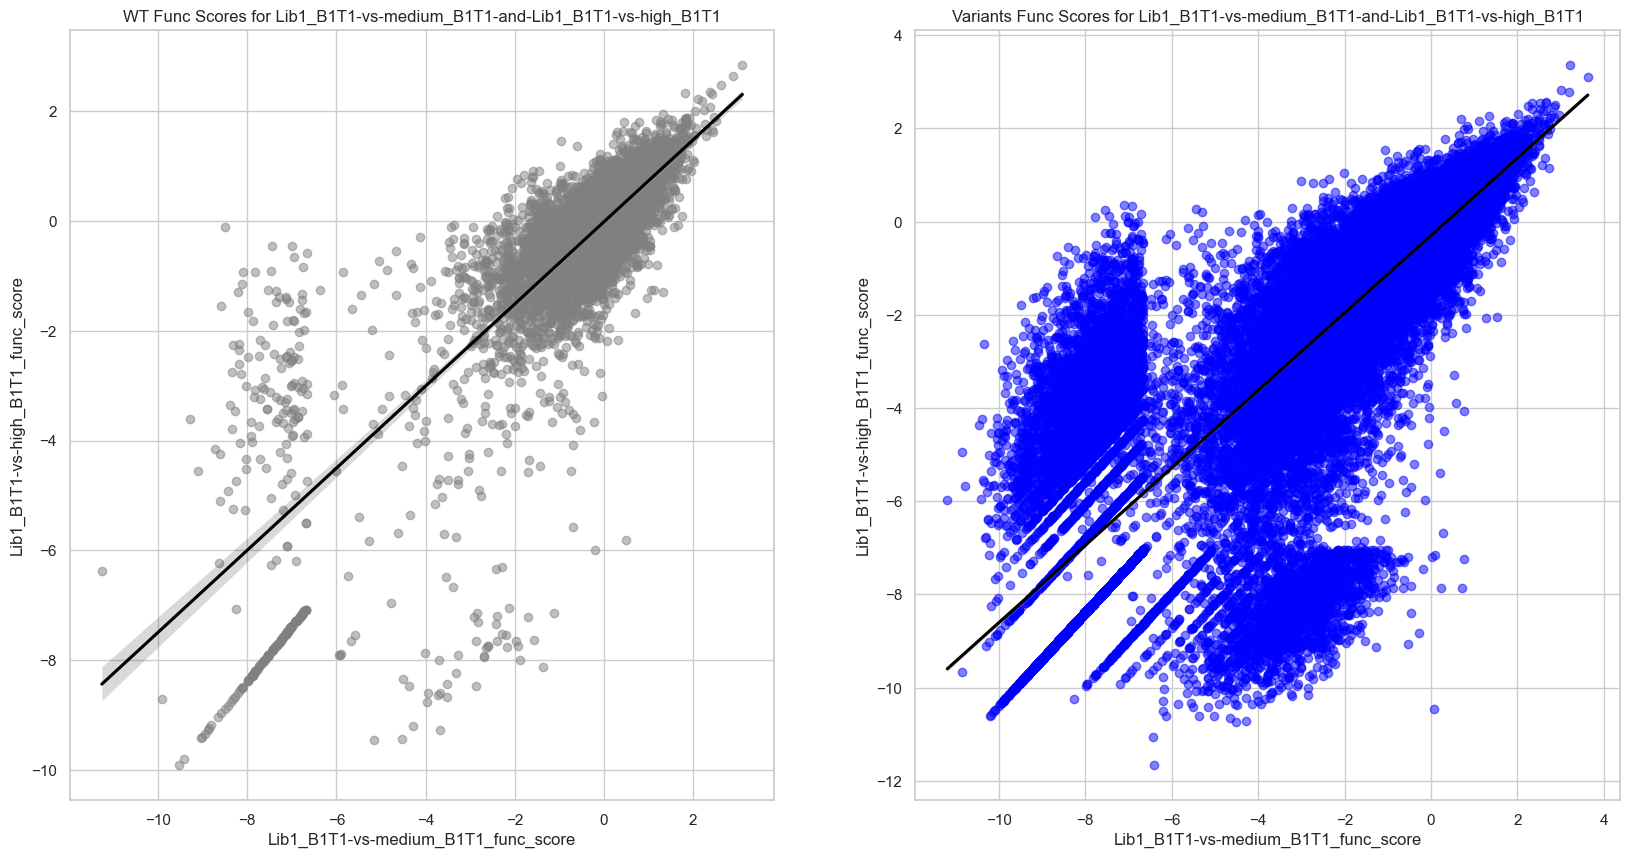

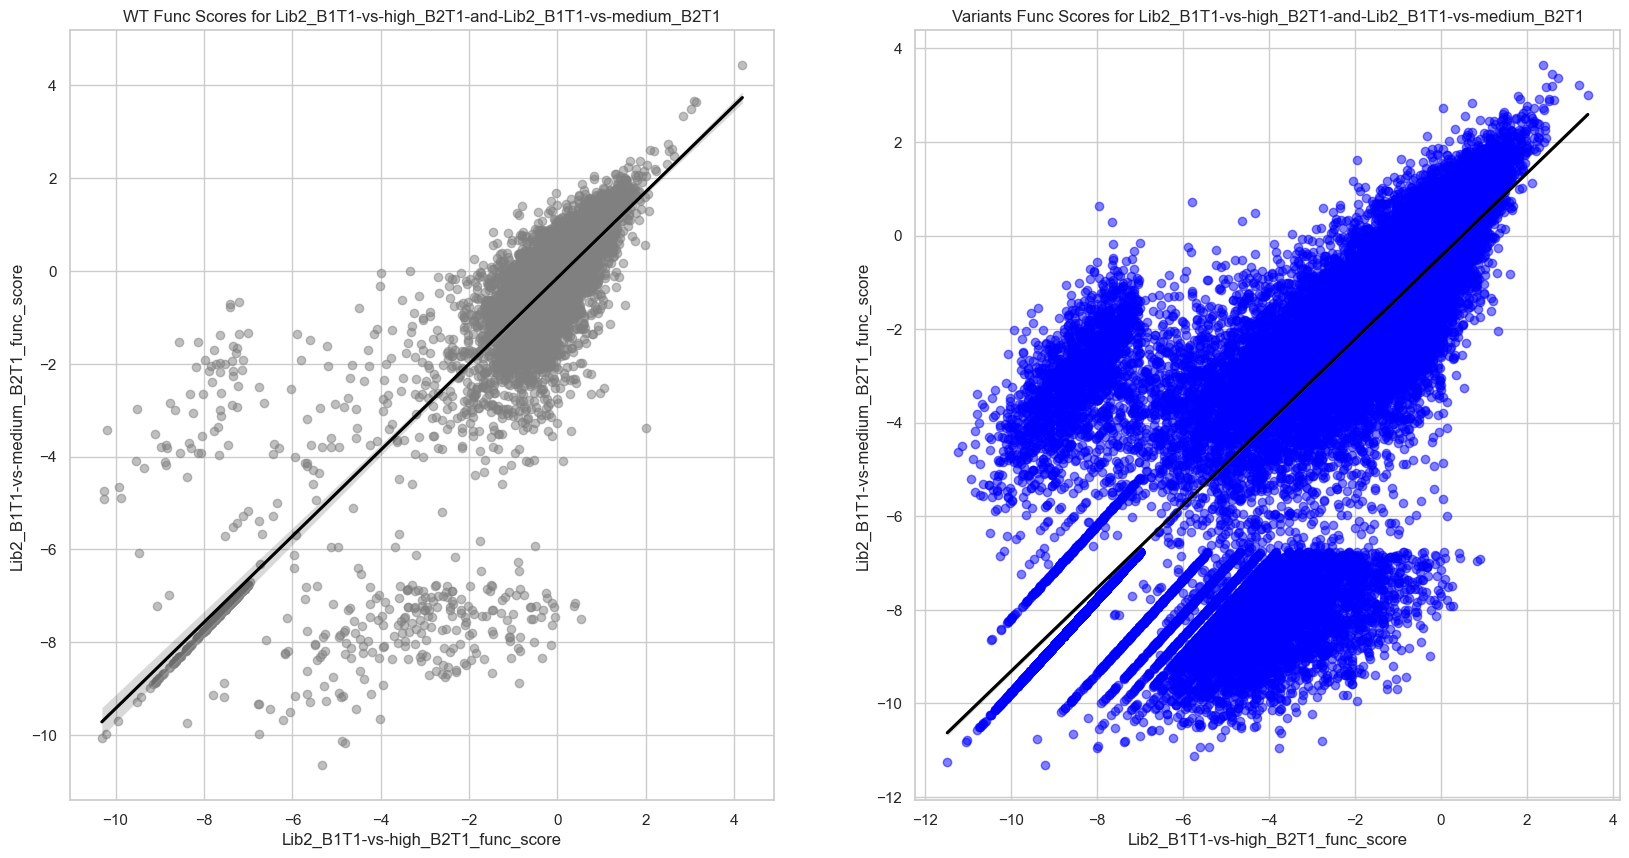

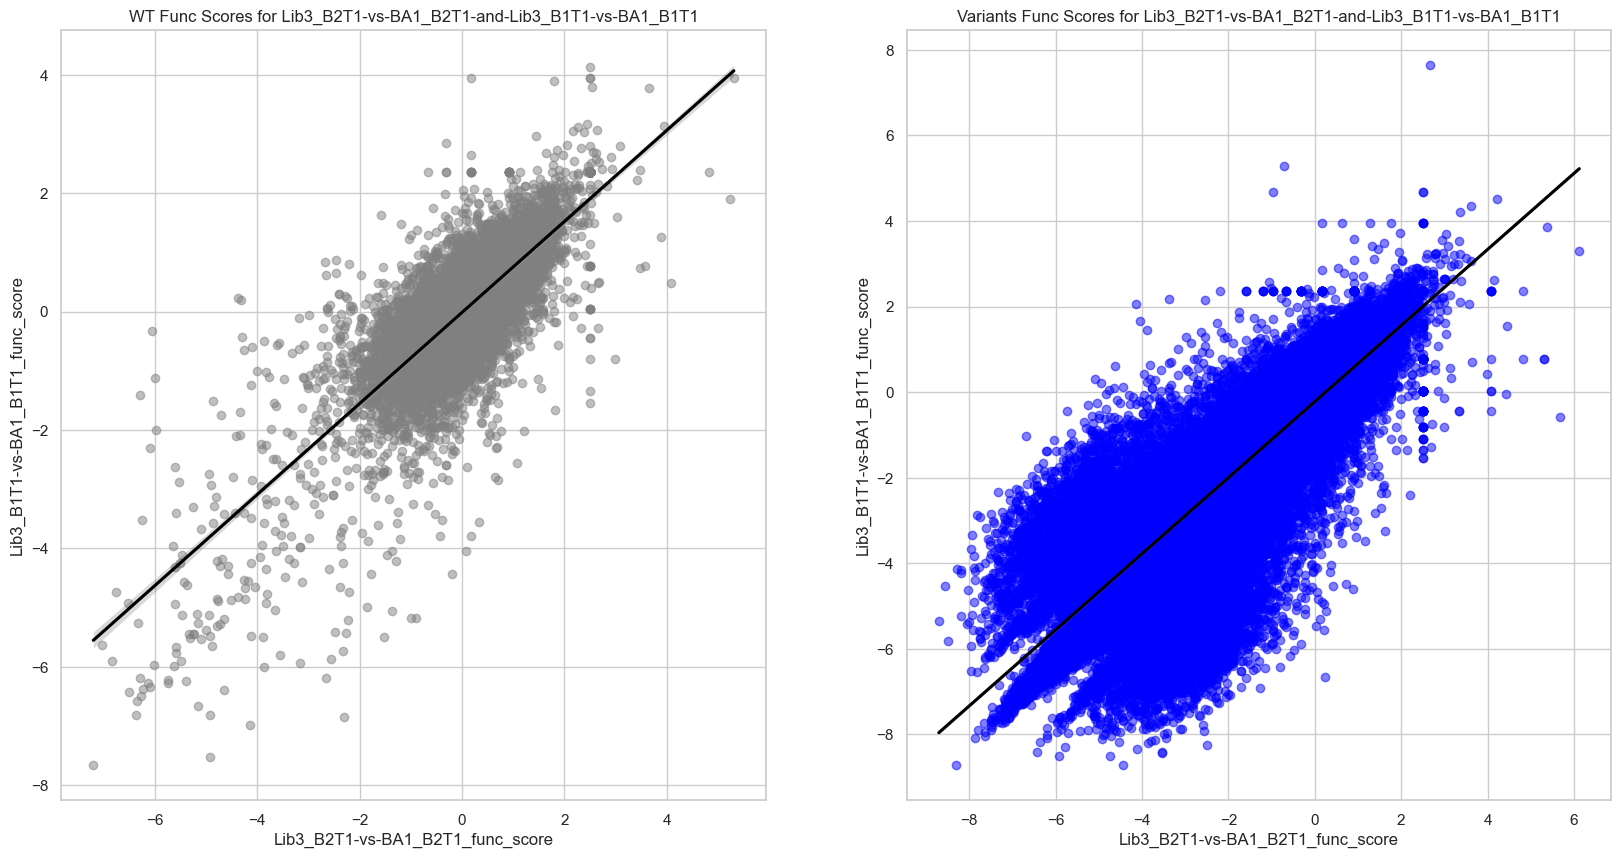

In [49]:
# Set plot style
sns.set(style='whitegrid')

# Define colors for n_selections
palette = {0: 'grey', 1: 'red', 2: 'blue'}

for key, df in merged_group_dict.items():
    # Filter out '_func_score_var' columns and select only '_func_score' columns
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]
    
    # Drop rows with NaN values
    df_clean = df.dropna(subset=func_score_columns)

    # Separate DataFrame for WT and Variants
    df_wt = df_clean[df_clean['n_aa_substitutions'] == 0]
    df_variants = df_clean[df_clean['n_aa_substitutions'] > 0]

    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for WT
    sns.regplot(x=func_score_columns[0], y=func_score_columns[1], data=df_wt, ax=axes[0], line_kws={'color': 'black'}, scatter_kws={'alpha': 0.5, 'color': 'grey'})
    axes[0].set_title(f'WT Func Scores for {key}')
    axes[0].set_xlabel(func_score_columns[0])
    axes[0].set_ylabel(func_score_columns[1])
    axes[0].grid(True)

    # Plot for Variants
    sns.regplot(x=func_score_columns[0], y=func_score_columns[1], data=df_variants, ax=axes[1], line_kws={'color': 'black'}, scatter_kws={'alpha': 0.5, 'color': 'blue'})
    axes[1].set_title(f'Variants Func Scores for {key}')
    axes[1].set_xlabel(func_score_columns[0])
    axes[1].set_ylabel(func_score_columns[1])
    axes[1].grid(True)

    # Show or save the plot
    plt.show()

    # Close the plot to avoid overlapping plots in the next iteration
    plt.close()


/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

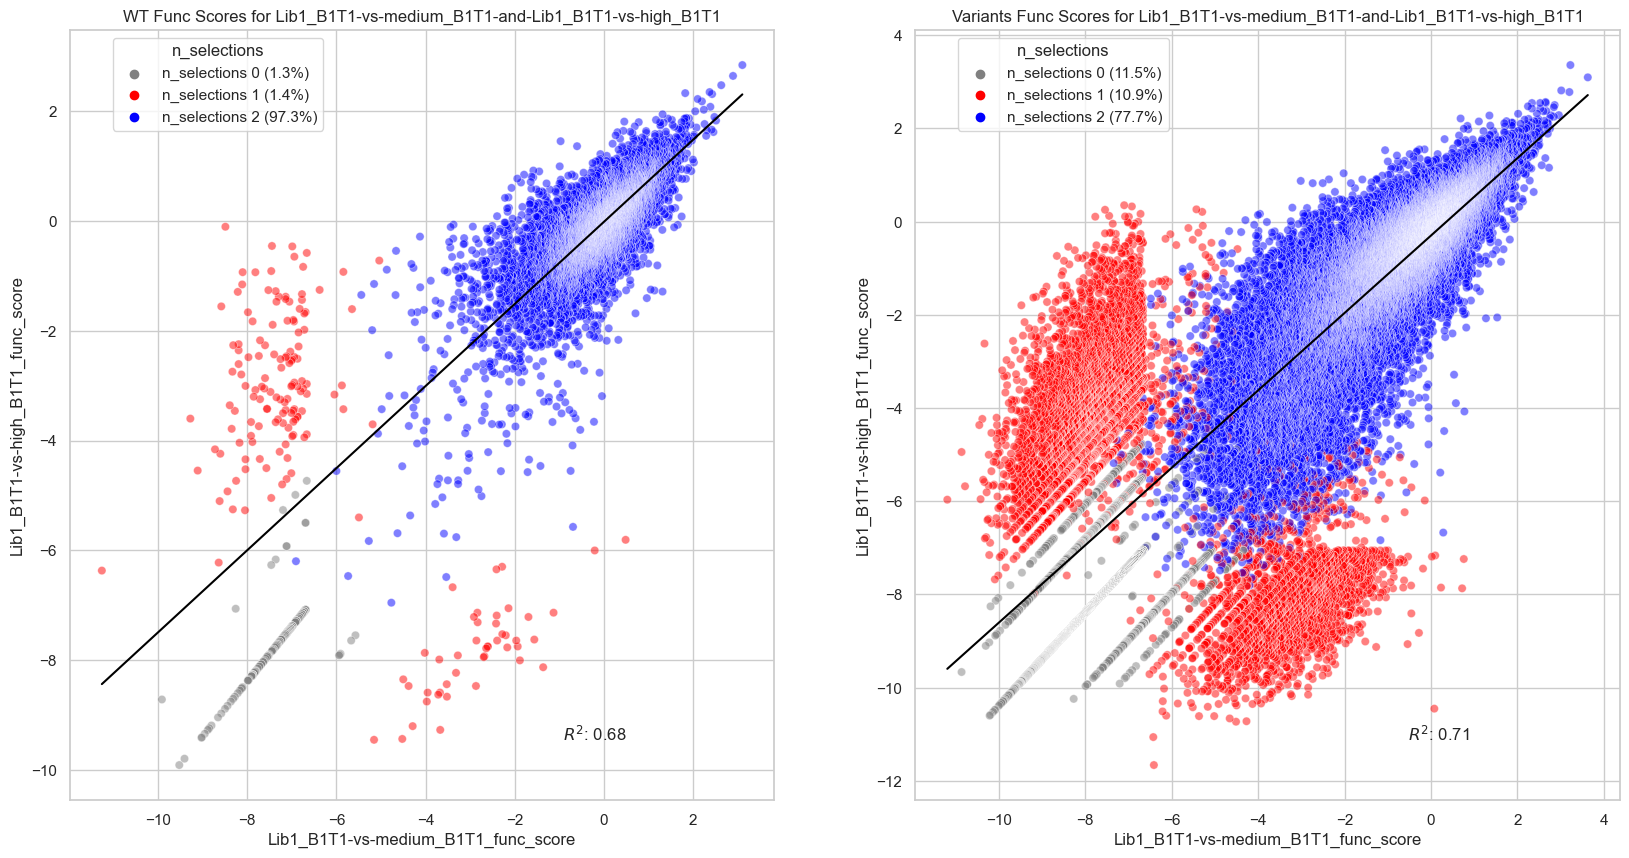

/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

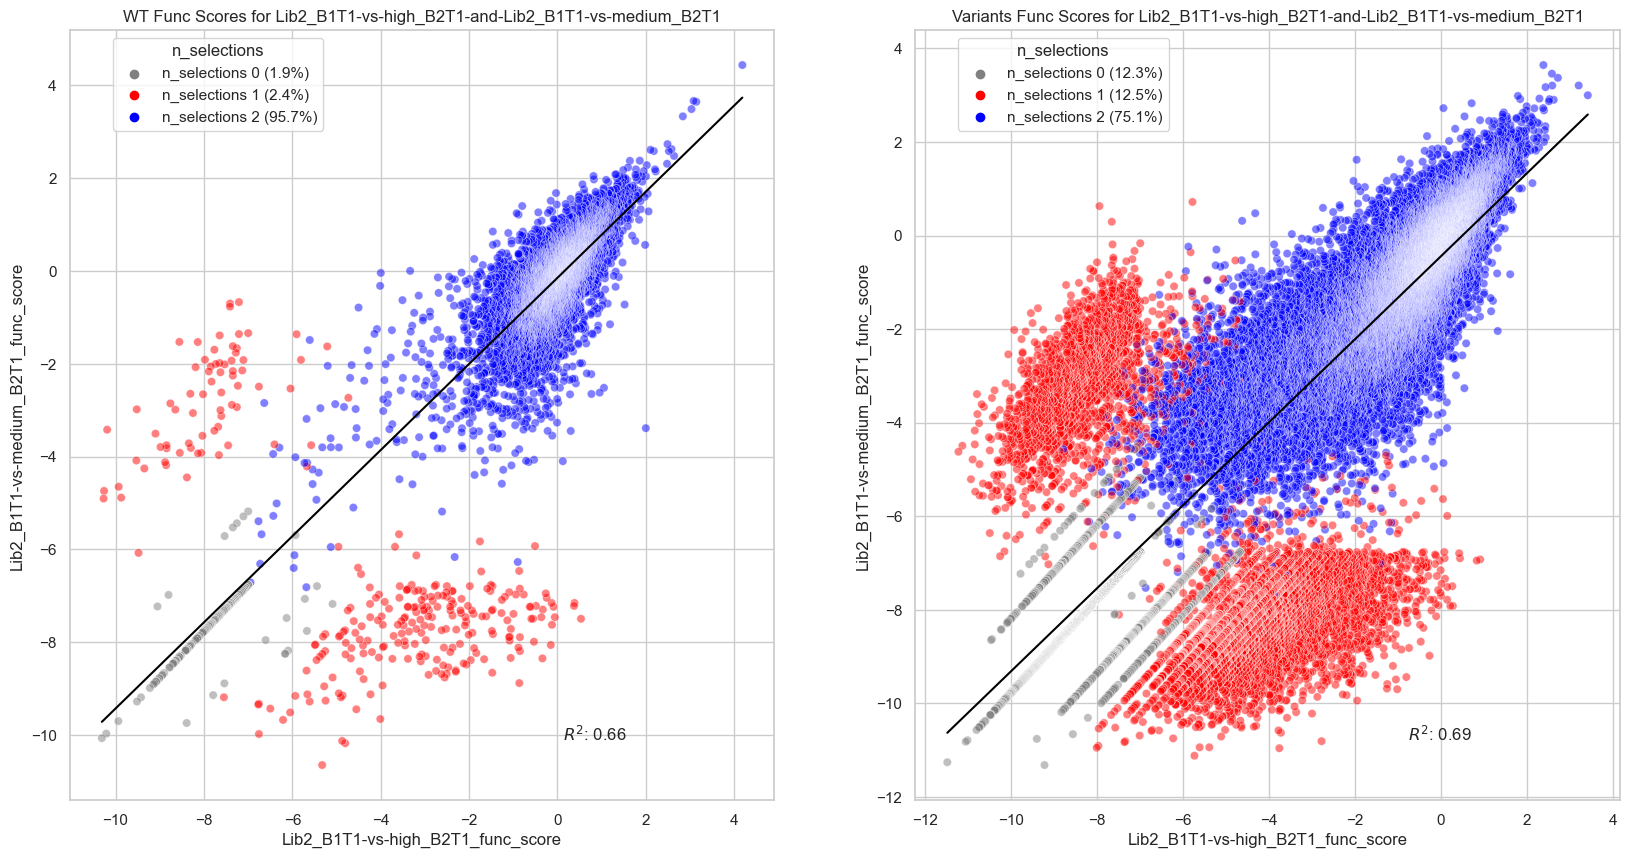

In [16]:
# Set plot style
sns.set(style='whitegrid')

# Define colors for n_selections
palette = {0: 'grey', 1: 'red', 2: 'blue'}

for key, df in merged_group_dict.items():
    # Filter out '_func_score_var' columns and select only '_func_score' columns
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]
    
    # Drop rows with NaN values
    df_clean = df.dropna(subset=func_score_columns)

    # Separate DataFrame for WT and Variants
    df_wt = df_clean[df_clean['n_aa_substitutions'] == 0]
    df_variants = df_clean[df_clean['n_aa_substitutions'] > 0]

    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for WT
    sns.scatterplot(x=func_score_columns[0], y=func_score_columns[1], data=df_wt, hue='n_selections', palette=palette, ax=axes[0], alpha=0.5)
    slope, intercept, r_value, _, _ = linregress(df_wt[func_score_columns[0]], df_wt[func_score_columns[1]])
    axes[0].plot(df_wt[func_score_columns[0]], slope*df_wt[func_score_columns[0]] + intercept, color='black')
    axes[0].set_title(f'WT Func Scores for {key}')
    axes[0].set_xlabel(func_score_columns[0])
    axes[0].set_ylabel(func_score_columns[1])
    axes[0].grid(True)
    # Annotate R^2 value
    axes[0].text(0.7, 0.1, f'$R^2$: {r_value**2:.2f}', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

    # Plot for Variants
    sns.scatterplot(x=func_score_columns[0], y=func_score_columns[1], data=df_variants, hue='n_selections', palette=palette, ax=axes[1], alpha=0.5)
    slope, intercept, r_value_var, _, _ = linregress(df_variants[func_score_columns[0]], df_variants[func_score_columns[1]])
    axes[1].plot(df_variants[func_score_columns[0]], slope*df_variants[func_score_columns[0]] + intercept, color='black')
    axes[1].set_title(f'Variants Func Scores for {key}')
    axes[1].set_xlabel(func_score_columns[0])
    axes[1].set_ylabel(func_score_columns[1])
    axes[1].grid(True)
    # Annotate R^2 value
    axes[1].text(0.7, 0.1, f'$R^2$: {r_value_var**2:.2f}', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

    # Adjust the legends
    for ax, df_subset in zip(axes, [df_wt, df_variants]):
        handles, labels = ax.get_legend_handles_labels()
        new_labels = []
        for label in labels:
            if label in ['0', '1', '2']:
                n_sel = int(label)
                percentage = (df_subset['n_selections'] == n_sel).mean() * 100
                new_labels.append(f'n_selections {label} ({percentage:.1f}%)')
            else:
                new_labels.append(label)
        ax.legend(handles, new_labels, title='n_selections', bbox_to_anchor=(0.05, 1), loc=2)

    # Show or save the plot
    plt.show()

    # Close the plot to avoid overlapping plots in the next iteration
    plt.close()

In [ ]:
def plot_count_histograms(df, key):
    # Check if DataFrame contains all required n_selections values
    if all(n in df['n_selections'].unique() for n in [0, 1, 2]):
        # Identify DMSO_BxTx_count columns
        dmso_count_cols = [col for col in df.columns if '_count' in col and 'Lib' in col]

        if len(dmso_count_cols) == 2:
            
            print(f"Plotting for {key}...")

            # Initialize maximum frequency and define bins and colors
            max_frequency, bins, colors = 0, 30, ['red', 'blue']
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create subplots

            for i, n_sel in enumerate([0, 1, 2]):
                df_filtered = df[df['n_selections'] == n_sel]
                for col, color in zip(dmso_count_cols, colors):
                    counts, bin_edges = np.histogram(df_filtered[col].dropna(), bins=bins)
                    max_frequency = max(max_frequency, max(counts))

                    sns.histplot(df_filtered[col], ax=axes[i], bins=bins, kde=False, alpha=0.5, color=color, label=col)

                axes[i].set_yscale('log')
                axes[i].set_title(f'(n_selections = {n_sel})')
                axes[i].set_xlabel('Count')
                axes[i].set_ylabel('Number of Barcodes' if i == 0 else '')
                axes[i].legend()

            for ax in axes:
                ax.set_ylim(1, max_frequency * 1.5)

            plt.tight_layout()
            plt.show()
        else:
            print(f"Expected two DMSO count columns, found {len(dmso_count_cols)}")
    else:
        print(f"Skipping {key} as it does not contain all n_selections values (0, 1, 2)")

In [28]:
# specific_key = '4u8c_B2T1-vs-DMSO_B1T2-and-4u8c_B2T2-vs-DMSO_B1T1'  # Replace this with the actual key you want to use

# # Access the DataFrame using the key
# specific_df = merged_group_dict[specific_key]

# # Display the column names
# print(specific_df.head())


   4u8c_B2T1-vs-DMSO_B1T2_func_score  4u8c_B2T1-vs-DMSO_B1T2_func_score_var  \
0                              4.090                                0.03028   
1                              3.651                                0.03042   
2                              3.633                                0.02745   
3                              3.623                                0.03317   
4                              3.540                                0.03432   

            barcode         aa_substitutions  n_aa_substitutions  \
0  AGAGTTTTAGAAAACT  D80A Q677M G889W R1014K                   4   
1  GCAGCCATGCAAGCTC                    S939L                   1   
2  ATTAAAGATGATAAGG         T22N L176S P209T                   3   
3  CTACAAGCCCACCCAA                     T29L                   1   
4  GAAACCTTTAACCACA                    L176M                   1   

   n_codon_substitutions  4u8c_B2T1_count  DMSO_B1T2_count  \
0                      4           1326.0             

Expected two DMSO count columns, found 1
Expected two DMSO count columns, found 1
Plotting for Lib3_B2T1-vs-BA1_B2T1-and-Lib3_B1T1-vs-BA1_B1T1...


/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

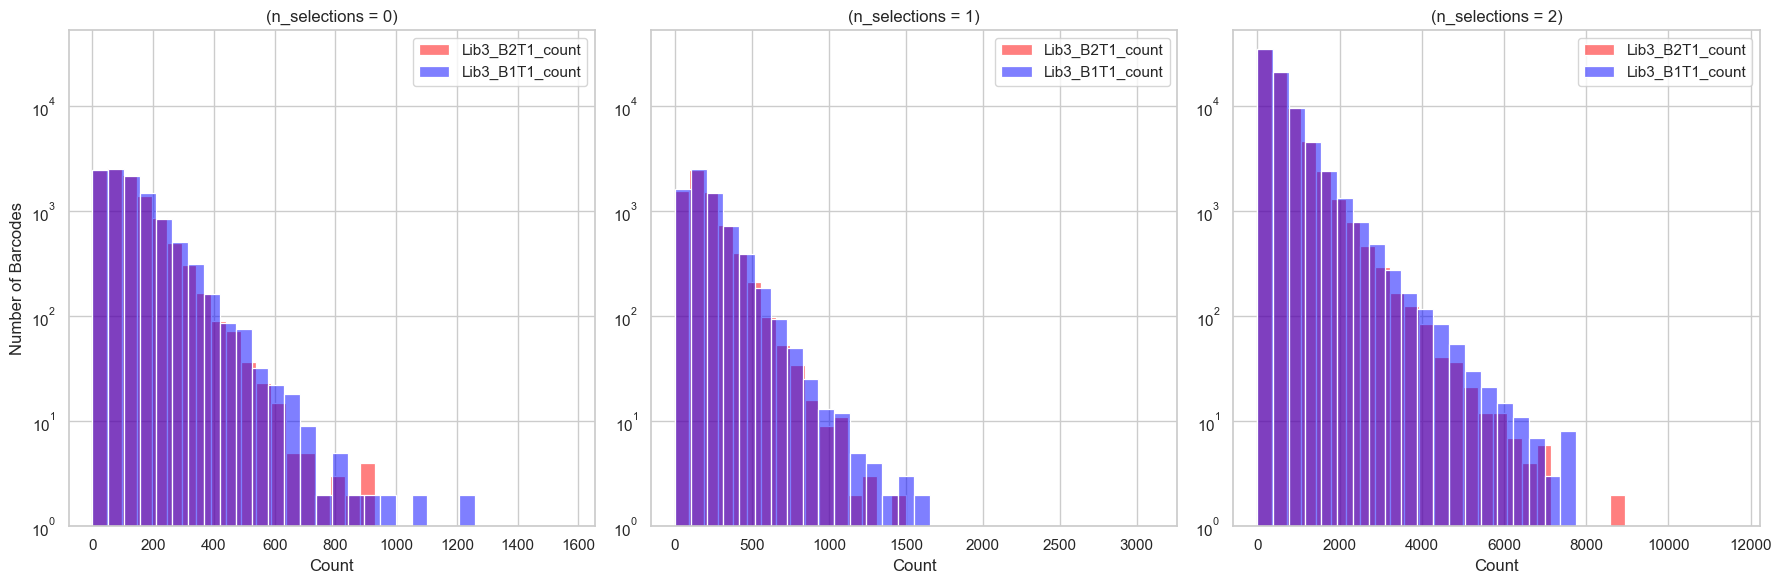

In [52]:
# Loop through all DataFrames in merged_group_dict
for key, df in merged_group_dict.items():
    plot_count_histograms(df, key)

In [50]:
def calculate_n_selections_plotting(df, threshold, non_dmso_count_cols):
    df['n_selections'] = (df[non_dmso_count_cols] >= threshold).sum(axis=1)
    return df

def plot_r2_vs_threshold(df, key, threshold):
    thresholds = range(1, threshold)
    r2_values = []

    # Identify non-DMSO count columns and func_score columns
    non_dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' not in col]
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]

    # Ensure there are exactly 2 func_score columns to plot
    if len(func_score_columns) == 2:
        for threshold in thresholds:
            df_threshold = calculate_n_selections_plotting(df.copy(), threshold, non_dmso_count_cols)
            df_filtered = df_threshold[df_threshold['n_selections'] != 1]

            if not df_filtered.empty:
                slope, intercept, r_value, p_value, std_err = linregress(df_filtered[func_score_columns[0]], df_filtered[func_score_columns[1]])
                r2_values.append(r_value**2)
            else:
                r2_values.append(np.nan)

        plt.figure(figsize=(10, 6))
        sns.lineplot(x=thresholds, y=r2_values)
        plt.title('R² vs. Minimim barcode counts')
        plt.title(f'{key}')
        plt.xlabel('Minimum Barcode Counts')
        plt.ylabel('R² Value')
        plt.show()
    else:
        print("Expected exactly 2 func_score columns.")

# Example usage
# Assuming you have a DataFrame named 'df_example'
# plot_r2_vs_threshold(df_example)

/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

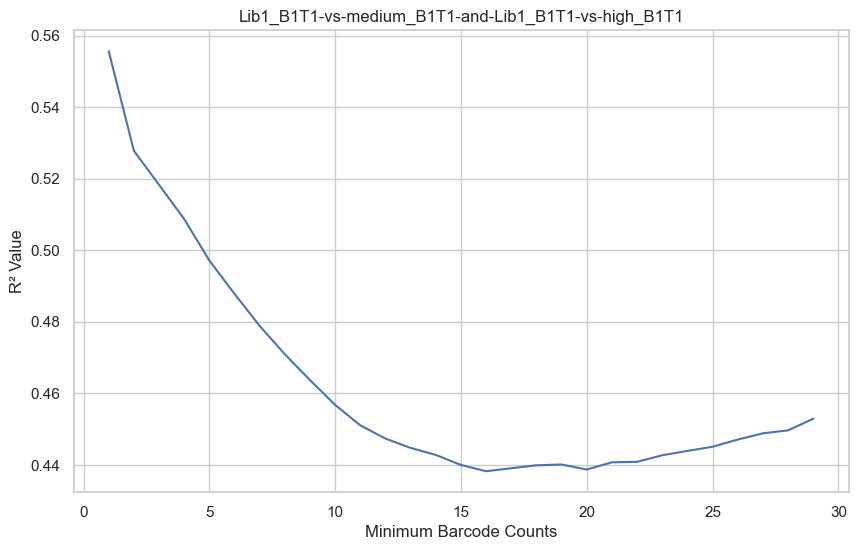

/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

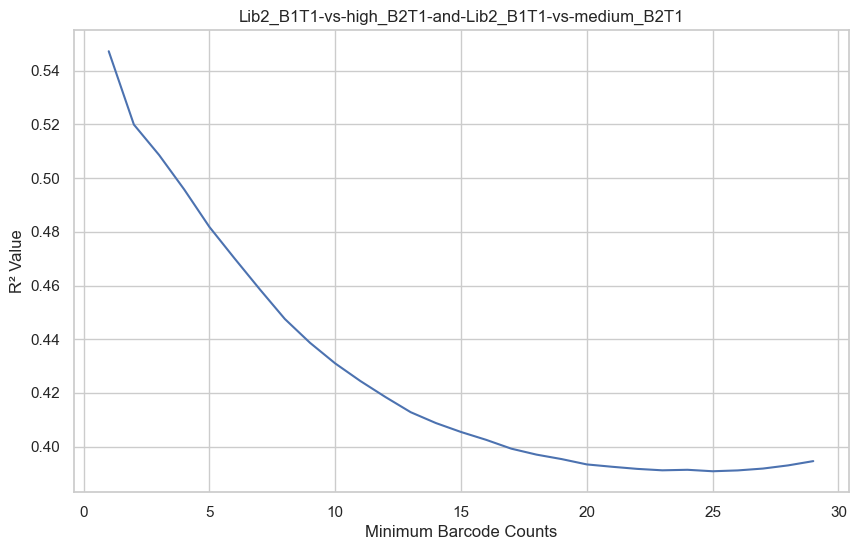

/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/keithwalcott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

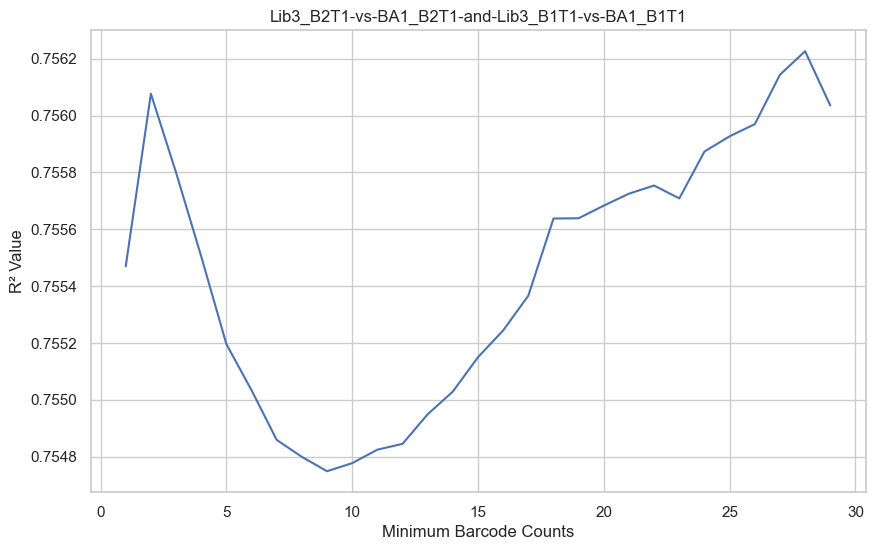

In [51]:
# Loop through all DataFrames in merged_group_dict
for key, df in merged_group_dict.items():
    plot_r2_vs_threshold(df,key,30)

In [29]:
# Assuming merged_group_dict is your dictionary of DataFrames
# Replace 'example_key' with the actual key of the DataFrame you want to analyze
df_example = merged_group_dict['4u8c_B2T1-vs-DMSO_B1T2-and-4u8c_B2T2-vs-DMSO_B1T1']

def calculate_n_selections_optimized(df, threshold):
    non_dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' not in col]
    df['n_selections'] = (df[non_dmso_count_cols] >= threshold).sum(axis=1)
    return df

def update_plot(threshold):
    df_threshold = calculate_n_selections_optimized(df_example.copy(), threshold)
    func_score_columns = [col for col in df_threshold.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]
    
    df_regression = df_threshold[df_threshold['n_selections'] != 1].dropna(subset=func_score_columns)

    slope, intercept, r_value, p_value, std_err = linregress(df_regression[func_score_columns[0]], df_regression[func_score_columns[1]])
    regression_x = np.linspace(df_regression[func_score_columns[0]].min(), df_regression[func_score_columns[0]].max(), 100)
    regression_y = regression_x * slope + intercept

    # Create scatter plot
    fig = go.Figure()
    for n_sel in sorted(df_threshold['n_selections'].unique()):
        df_subset = df_threshold[df_threshold['n_selections'] == n_sel]
        fig.add_trace(go.Scatter(x=df_subset[func_score_columns[0]], y=df_subset[func_score_columns[1]], mode='markers', 
                                 name=f'n_selections: {n_sel}', marker=dict(color=['grey', 'red', 'blue'][n_sel], size=10, opacity=0.5)))

    fig.add_trace(go.Scatter(x=regression_x, y=regression_y, mode='lines', name='Regression Line', line=dict(color='black')))

    fig.update_layout(title=f'Func Score Scatter Plot with Threshold {threshold} (R²: {r_value**2:.2f})',
                      xaxis_title=func_score_columns[0], yaxis_title=func_score_columns[1],
                      plot_bgcolor='white', showlegend=True, legend_title='Legend',
                      xaxis=dict(showgrid=True, gridcolor='lightgrey', zeroline=False, linewidth=2, linecolor='black'),
                      yaxis=dict(showgrid=True, gridcolor='lightgrey', zeroline=False, linewidth=2, linecolor='black'),
                      width=1000, height=1000)
    fig.show()

# Create slider widget
threshold_slider = widgets.IntSlider(min=1, max=25, step=1, value=20, description='Threshold', continuous_update=False)

# Bind the slider to the update function
widgets.interactive(update_plot, threshold=threshold_slider)


interactive(children=(IntSlider(value=20, continuous_update=False, description='Threshold', max=25, min=1), Ou…